(C) Copyright 2024 Federico Gallina, Matteo Bruschi, Barbara Fresch

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Mission **$\gamma$**:
# Secular Redfield Equation
#
<div>
<img src="Images\Mission gamma\Mission gamma.jpeg" width="500"/>
</div>

## Ultrafast cis-trans photoswitching
An example inspired by Hahn, S., Stock, G. _J. Chem. Phys._ **116**, 1085–1091 (2002)

### Getting started
Let's start with some preparations:

- We import some packages and methods

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from scipy.linalg import eigh, expm
from numba import njit, prange

- We do some magic for better plot visualization (we want ticks to be multiples of $\frac{\pi}{2}$ when we plot angles) (Source: $\href{https://stackoverflow.com/a/53586826/12045962}{\text{stackoverflow}})$

In [2]:
def multiple_formatter(denominator=2, number=pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

### System Hamiltonian

<div>
<img src="Images\Mission gamma\dihedral.png" width="300"/>
</div>

In this example, the system will be a chromophore with a dihedral angle $\varphi$ which convert between a _cis_ and _trans_ configuration.

The electronic degrees of freedom are modeled as a two-level system, with the ground state $| \psi_0 \rangle$ and the excited state $| \psi_1 \rangle$.

In the diabatic electronic representation, the system Hamiltonian $H_S$ is given by

$$
H_S =
\begin{bmatrix}
H_0^R & V_{01} \\
V_{10} & H_1^R
\end{bmatrix}
= |\psi_0\rangle\langle\psi_0| \otimes H_0^R + |\psi_1\rangle\langle\psi_1| \otimes H_1^R + V_{01} |\psi_0\rangle\langle\psi_1| \otimes \mathbb{I} + V_{10} |\psi_1\rangle\langle\psi_0| \otimes \mathbb{I}
$$

where

$$
V_{01} = V_{10} = \lambda
$$

is the potential energy coupling between the diabatic electronic states, while

$$
H_n^R = T + V_{nn}
$$

is the Hamiltonian relative to the rotational degree of freedom for the ground ($n=0$) and excited ($n=1$) electronic state.

In these last terms

$$
T = - \frac{1}{2m}\frac{\partial^2}{\partial\varphi^2}
$$

denotes the kinetic energy, while

$$
V_{00} = \frac{1}{2}W_0(1-\text{cos}\varphi),
$$

$$
V_{11} = E_1 - \frac{1}{2}W_1(1-\text{cos}\varphi),
$$

are the diabatic potential energies for the electronic ground and excited states, respectively.

Let's visualize some energy curves:

- We define the system parameters

In [3]:
m = 1 / (4.84E-4)                                # The effective mass of the system [eV]
E1 = 2.48                                        # Electronic energy offset [eV]
W0 = 3.6                                         # Amplitude of the energy of the ground state [eV]
W1 = 1.09                                        # Amplitude of the energy of the excited state [eV]
lam = 0.065                                      # Energy coupling [eV]
sys_param = {'m':m, 'E1':E1, 'W0':W0, 'W1':W1, 'lam':lam} # A dictionary with the system parameters

- We create an array with the angle values

In [4]:
n_phi = 2000                                     # Number of angles (use an even number please)
phi = np.linspace(- pi / 2, 3 * pi / 2, n_phi)   # The angles
dphi = phi[1] - phi[0]                           # The spacing

- We define some useful functions.
We recall that the potential energy matrix

$$
V = 
\begin{bmatrix}
V_{00} & \lambda \\
\lambda & V_{11}
\end{bmatrix}
$$

has eigenvalues:

$$
v_{\pm} = \frac{1}{2} (V_{00} + V_{11}) \pm \frac{1}{2} \sqrt{(V_{00} + V_{11})^2 - 4 (V_{00} V_{11} - \lambda^2)}
$$

In [5]:
def V00(sys_param, phi):
    return sys_param['W0'] / 2 * (1 - np.cos(phi))

def V11(sys_param, phi):
    return sys_param['E1'] - sys_param['W1'] / 2 * (1 - np.cos(phi))

def diabatic_representation(sys_param, phi):
    plt.plot(phi, V00(sys_param, phi), label=r'$V_{00}$')
    plt.plot(phi, V11(sys_param, phi), label=r'$V_{11}$')
    ax = plt.gca(); ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2)); ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.set_xlabel(r'$\varphi$'); ax.set_ylabel('potential energy')
    ax.legend()

def adiabatic_representation(sys_param, phi):
    v_p = 1/2 * (V00(sys_param, phi) + V11(sys_param, phi)) + 1/2 * np.sqrt((V00(sys_param, phi) + V11(sys_param, phi))**2 - 4 * (V00(sys_param, phi) * V11(sys_param, phi) - sys_param['lam']**2) )
    v_m = 1/2 * (V00(sys_param, phi) + V11(sys_param, phi)) - 1/2 * np.sqrt((V00(sys_param, phi) + V11(sys_param, phi))**2 - 4 * (V00(sys_param, phi) * V11(sys_param, phi) - sys_param['lam']**2) )
    plt.plot(phi, V00(sys_param, phi), '--k', lw=0.8, label=r'$V_{00}$')
    plt.plot(phi, V11(sys_param, phi), '--k', lw=0.8, label=r'$V_{11}$')
    plt.plot(phi, v_m, label=r'$v_-$')
    plt.plot(phi, v_p, label=r'$v_+$')
    ax = plt.gca(); ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2)); ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.set_xlabel(r'$\varphi$'); ax.set_ylabel('potential energy')
    ax.legend()

- Aaaaand plot!

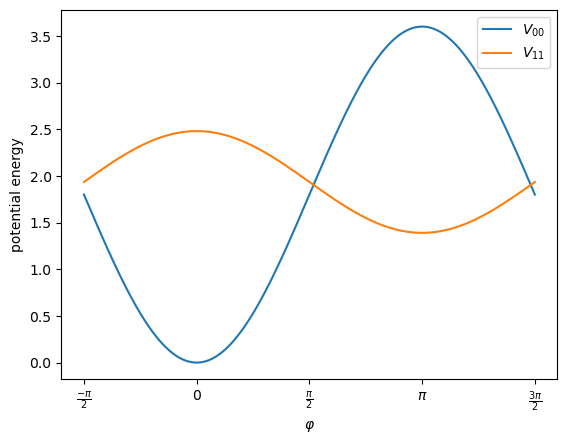

In [6]:
diabatic_representation(sys_param, phi)

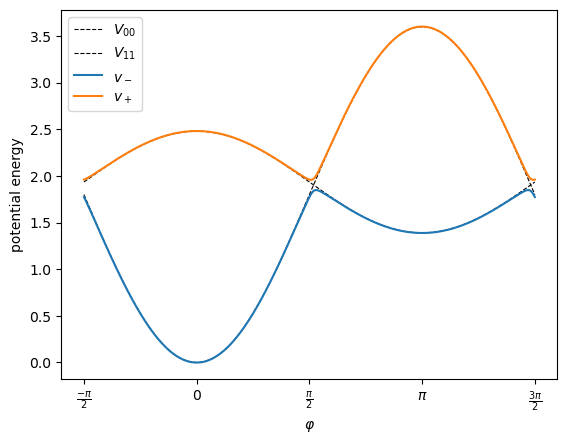

In [7]:
adiabatic_representation(sys_param, phi)

### Eigenstates of the system

We now want to see how the eigenstates are made.

To do so, we have to choose a basis set for the rotational degree of freedom.
Here, we use the eigenstates of the kinetic Hamiltonian $T$, which are

$$
| k \rangle = \frac{e^{ik\varphi}}{\sqrt{2\pi}},
$$

with $k$ ranging from $-\infty$ to $\infty$.

However, since the basis set is infinitely large, we have to choose a cutoff ($-k_\text{max} \leq k \leq k_\text{max}$) so that we can numerically implement the problem.

Matrices $T$, $V_{00}$ and $V_{11}$ are constructed as

$$
O = \sum_{k,k'} \langle k | O | k' \rangle
$$

with

$$
\langle k | O | k' \rangle = \frac{1}{2\pi} \int_{-\frac{\pi}{2}}^{\frac{3\pi}{2}} e^{-ik\varphi} O e^{ik'\varphi} d\varphi
$$

where the integrals are analytical in our case.

In [8]:
k_max = 150
N_rotor_states = 2 * k_max + 1
k = np.arange(- k_max, k_max + 1, 1)
T = np.diag(k)**2 / 2 / m
V0 = W0 / 2 * (np.diag(np.ones(N_rotor_states)) - 1/2 * np.diag(np.ones(N_rotor_states - 1), k=1) - 1/2 * np.diag(np.ones(N_rotor_states - 1), k=-1))
V1 = E1 * np.diag(np.ones(N_rotor_states)) - W1 / 2 * (np.diag(np.ones(N_rotor_states)) - 1/2 * np.diag(np.ones(N_rotor_states - 1), k=1) - 1/2 * np.diag(np.ones(N_rotor_states - 1), k=-1))
H_R0 = T + V0
H_R1 = T + V1
H_S = (np.kron(np.array([[1,0],[0,0]]), H_R0) +
       np.kron(np.array([[0,0],[0,1]]), H_R1) +
       np.kron(np.array([[0,1],[1,0]]), np.eye(N_rotor_states) * lam))

Now, we diagonalize

In [9]:
eigval_R0, eigvec_R0 = eigh(H_R0)
eigval_R1, eigvec_R1 = eigh(H_R1)
eigval_S, eigvec_S = eigh(H_S)
eigvec_S = eigvec_S.astype(np.complex128)        # Here, we impose the format of the values in eigvec_S as complexes

We define some routines for plotting the eigenstates

In [10]:
def show_eigvec_R0(phi, sys_param, eigvec, eigval, numbers):
    plt.plot(phi, V00(sys_param, phi), label=r'$V_{00}$')
    plt.plot(phi, V11(sys_param, phi), ':', label=r'$V_{11}$')
    if np.isscalar(numbers):
        numbers = [numbers]
    N_rotor_states = np.shape(eigvec)[0]
    k_max = (N_rotor_states - 1) / 2
    k = np.arange(-k_max,k_max+1,1)
    Phi_mesh, K_mesh = np.meshgrid(phi, k)
    for number in numbers:
        _, eigvec_mesh = np.meshgrid(phi, eigvec[:, number])
        A = eigvec_mesh * np.exp(1.j * Phi_mesh * K_mesh) / np.sqrt(2 * pi)
        A = np.sum(A, axis=0)
        A = np.abs(A)**2
        plt.plot(phi, eigval[number] * np.ones_like(phi), 'k:', lw=0.5)
        plt.plot(phi, A + eigval[number], label='eigvec_R0 {}'.format(number))
    ax = plt.gca(); ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2)); ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.set_xlabel(r'$\varphi$')
    ax.legend()
    ax.set_ylim(-0.25,4.75)
    
def show_eigvec_R1(phi, sys_param, eigvec, eigval, numbers):
    plt.plot(phi, V00(sys_param, phi), ':', label=r'$V_{00}$')
    plt.plot(phi, V11(sys_param, phi), label=r'$V_{11}$')
    if np.isscalar(numbers):
        numbers = [numbers]
    N_rotor_states = np.shape(eigvec)[0]
    k_max = (N_rotor_states - 1) / 2
    k = np.arange(-k_max,k_max+1,1)
    Phi_mesh, K_mesh = np.meshgrid(phi, k)
    for number in numbers:
        _, eigvec_mesh = np.meshgrid(phi, eigvec[:, number])
        A = eigvec_mesh * np.exp(1.j * Phi_mesh * K_mesh) / np.sqrt(2 * pi)
        A = np.sum(A, axis=0)
        A = np.abs(A)**2
        plt.plot(phi, eigval[number] * np.ones_like(phi), 'k:', lw=0.5)
        plt.plot(phi, A + eigval[number], label='eigvec_R1 {}'.format(number))
    ax = plt.gca(); ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2)); ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.set_xlabel(r'$\varphi$')
    ax.legend()
    ax.set_ylim(-0.25,4.75)
    
def show_eigvec_S(phi, sys_param, eigvec, eigval, numbers):
    adiabatic_representation(sys_param, phi)
    if np.isscalar(numbers):
        numbers = [numbers]
    N_rotor_states = np.shape(eigvec)[0]/2
    k_max = (N_rotor_states - 1) / 2
    k = np.arange(-k_max,k_max+1,1)
    k = np.concatenate((k,k))
    Phi_mesh, K_mesh = np.meshgrid(phi, k)
    for number in numbers:
        _, eigvec_mesh = np.meshgrid(phi, eigvec[:, number])
        A = eigvec_mesh * np.exp(1.j * Phi_mesh * K_mesh) / np.sqrt(2 * pi)
        A = np.sum(A, axis=0)
        A = np.abs(A)**2
        plt.plot(phi, eigval[number] * np.ones_like(phi), 'k:', lw=0.5)
        plt.plot(phi, A + eigval[number], label='eigvec_S {}'.format(number))
    ax = plt.gca(); ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2)); ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
    ax.set_xlabel(r'$\varphi$'); ax.set_ylabel('')
    ax.legend()
    ax.set_ylim(-0.25,4.75)

and, finally, we plot the eigenstates of:
- $V_{00}$

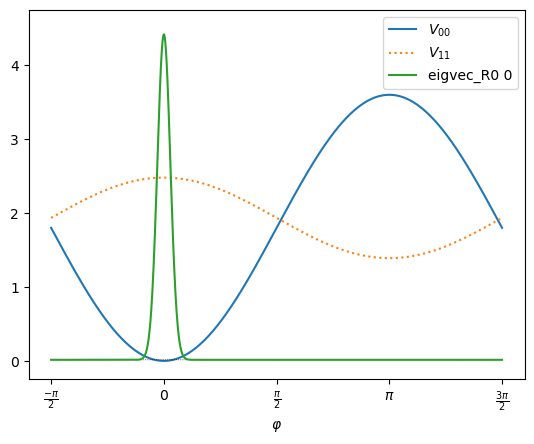

In [11]:
show_eigvec_R0(phi, sys_param, eigvec_R0, eigval_R0, 0)

- $V_{11}$

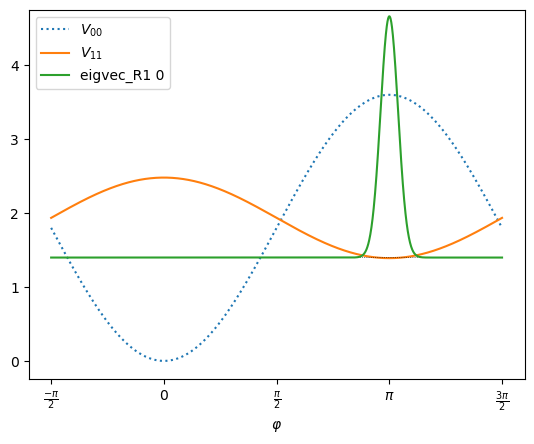

In [12]:
show_eigvec_R1(phi, sys_param, eigvec_R1, eigval_R1, 0)

- $V$

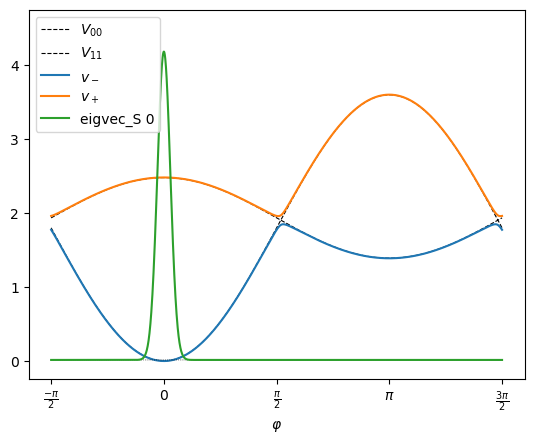

In [13]:
show_eigvec_S(phi, sys_param, eigvec_S, eigval_S, 0)

### Schrödinger dynamics
Let's see how the system evolves in time.

We define the time array

In [14]:
dt_ps = 0.01                                     # Time step [ps]
tmax_ps = 3                                      # Max time [ps]
t_ps = np.arange(0, tmax_ps, dt_ps)              # Time array [ps]
dt = dt_ps / 0.004136 * 2 * pi                   # Time step [1/eV]
tmax = tmax_ps / 0.004136 * 2 * pi               # Max time [1/eV]
t = t_ps / 0.004136 * 2 * pi                     # Time array [1/eV]

We assume the initial state to be prepared from an electronic excitation of the ground state of $H_S$ ($| \Psi^S_0 \rangle$)

$$
| \Psi (0) \rangle = \sigma^x \otimes \mathbb{1} | \Psi^S_0 \rangle
$$

In [15]:
Psi0S = np.zeros(N_rotor_states * 2, dtype=complex)
Psi0S[0] = 1
Psi = np.zeros((N_rotor_states * 2, len(t)), dtype=complex)
Psi[:,0] = np.conj(eigvec_S).T @ np.kron(np.array([[0, 1], [1, 0]]), np.eye(N_rotor_states)) @ eigvec_S @ Psi0S

We propagate the dynamics with the exact solution of the Schrödinger equation for a time-independent Hamiltonian

$$
|\Psi(t+\delta t)\rangle = e^{-iH_St} |\Psi(t)\rangle
$$

In [16]:
U = np.diag(np.exp(- 1.j * eigval_S * dt))       # Schoedinger propagator for a time step
for i in range(1, len(t)):
    Psi[:,i] = U @ Psi[:,i-1]                    # Updating the statevector

Now, we define some observables of the system that can be of interest.

In particular, we define 2 projector operators for the rotational degree of freedom

$$
P^{trans} = \Theta(|\varphi| - \pi/2),\text{          }-\pi/2 \leq\varphi<3\pi/2
$$

$$
P^{cis} = \mathbb{1} - P^{trans} = \Theta(\pi/2 - |\varphi|),\text{          }-\pi/2 \leq\varphi<3\pi/2
$$

In [17]:
Phi_mesh, K_mesh = np.meshgrid(phi, k)
T = np.exp(1.j * Phi_mesh * K_mesh) / np.sqrt(n_phi) # Fourier transformer from angles to momenta
Pt = T @ np.diag(np.concatenate((np.zeros(n_phi//2), np.ones(n_phi//2)))) @ np.conj(T).T
Pc = T @ np.diag(np.concatenate((np.ones(n_phi//2), np.zeros(n_phi//2)))) @ np.conj(T).T   

and 2 for the electronic degree of freedom

$$
P_n = | \psi_n \rangle \langle \psi_n |
$$

In [18]:
P0 = np.array([[1, 0], [0, 0]])
P1 = np.array([[0, 0], [0, 1]])

By combining them, we get

$$
P_n^x = P_n \otimes P^x
$$

with $n=\{0,1\}$ and $x=\{trans,\text{ }cis\}$

In [19]:
P0t = np.conj(eigvec_S).T @ np.kron(P0, Pt) @ eigvec_S 
P0c = np.conj(eigvec_S).T @ np.kron(P0, Pc) @ eigvec_S 
P1t = np.conj(eigvec_S).T @ np.kron(P1, Pt) @ eigvec_S 
P1c = np.conj(eigvec_S).T @ np.kron(P1, Pc) @ eigvec_S 

When we take the expectation value of a projector

$$
P_n^x (t) = 
\begin{cases}
    \langle \Psi(t) | P_n^x | \Psi(t) \rangle, & \text{ for a statevector} \\
    \\
    \text{Tr} \left\{ \rho(t) P_n^x \right\}, & \text{ for a density matrix}
\end{cases}
$$

we get the probability of being in the $n$ (ground or excited) diabatic state with conformation $x$ (trans or cis).

In [20]:
@njit
def observables_sv(t, states, P0t, P0c, P1t, P1c):
    P_0_t = np.zeros(len(t), dtype=np.complex128)
    P_0_c = np.zeros(len(t), dtype=np.complex128)
    P_1_t = np.zeros(len(t), dtype=np.complex128)
    P_1_c = np.zeros(len(t), dtype=np.complex128)
    for i in prange(0, len(t)):
        P_0_t[i] = np.conj(states[:,i]).T @ P0t @ Psi[:,i]
        P_0_c[i] = np.conj(states[:,i]).T @ P0c @ Psi[:,i]
        P_1_t[i] = np.conj(states[:,i]).T @ P1t @ Psi[:,i]
        P_1_c[i] = np.conj(states[:,i]).T @ P1c @ Psi[:,i]
    return P_0_t, P_0_c, P_1_t, P_1_c

@njit
def observables_dm(t, states, P0t, P0c, P1t, P1c):
    P_0_t = np.zeros(len(t), dtype=np.complex128)
    P_0_c = np.zeros(len(t), dtype=np.complex128)
    P_1_t = np.zeros(len(t), dtype=np.complex128)
    P_1_c = np.zeros(len(t), dtype=np.complex128)
    for i in prange(0, len(t)):
        P_0_t[i] = np.trace(states[:,:,i] @ P0t)
        P_0_c[i] = np.trace(states[:,:,i] @ P0c)
        P_1_t[i] = np.trace(states[:,:,i] @ P1t)
        P_1_c[i] = np.trace(states[:,:,i] @ P1c)
    return P_0_t, P_0_c, P_1_t, P_1_c

def observables(t, states, P0t, P0c, P1t, P1c):
    if np.ndim(states)-1 == 2:                   # Density matrix
        return observables_dm(t, states, P0t, P0c, P1t, P1c)
    elif np.ndim(states)-1 == 1:                 # Statevector
        return observables_sv(t, states, P0t, P0c, P1t, P1c)

Finally, we plot the results, i.e., the dynamics of the observables

C:\Users\fede\AppData\Local\Temp\ipykernel_21820\1911968536.py:8: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 1, 'C', False, aligned=True), Array(complex128, 1, 'A', True, aligned=True))
  P_0_t[i] = np.conj(states[:,i]).T @ P0t @ Psi[:,i]
C:\Users\fede\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


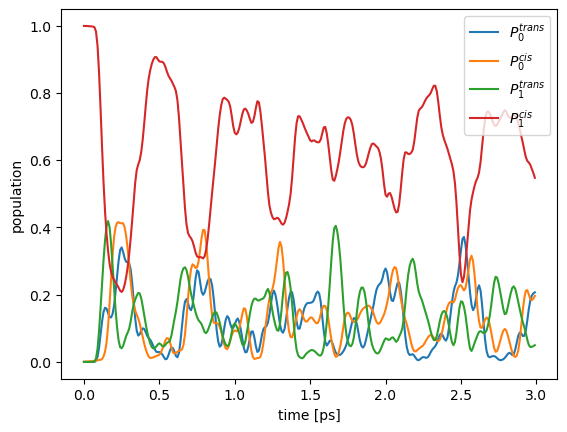

In [21]:
P = observables(t, Psi, P0t, P0c, P1t, P1c)
[plt.plot(t_ps, P[i]) for i in range(4)]
plt.legend([r'$P_0^{trans}$',r'$P_0^{cis}$',r'$P_1^{trans}$',r'$P_1^{cis}$'], loc=1)
plt.xlabel('time [ps]'); plt.ylabel('population');

### Redfield dynamics
The Schrödinger dynamics is informative for a closed system.

However, molecules are rarely closed systems, but interact with their environment.

When the interaction can be treated as a perturbation and the environment relaxation time is much faster than the system time scales (Markovian), the Redfield equation is a powerful tool for describing the dynamics of the (reduced) system.

Here, we assume the system is interacting with a collection of quantum harmonic oscillators (the _bath_), so that the universe Hamiltonian reads

$$
H = H_S + H_B + H_{SB}.
$$

The bath Hamiltonian is

$$
H_B = \sum_\alpha \omega_\alpha \left( a^\dagger_\alpha a_\alpha + \frac{1}{2} \right)
$$

with $\omega_\alpha$ the frequencies and $a_\alpha$ ($a^\dagger_\alpha$) the annihilation (creation) operators of the $\alpha$ vibrational mode, while

$$
H_{SB} = QF
$$

is the system-bath interaction Hamiltonian.
Operator Q acts on the system degrees of freedom and will be defined later, while the bath interaction operator is assumed to be

$$
F = \sum_\alpha \kappa_\alpha \left( a^\dagger_\alpha + a_\alpha \right)
$$

with $\kappa_\alpha$ the system-bath couplings.

With the Redfield treatment, the environment is accounted in an effective way, i.e., we do not need to introduce environmental degrees of freedom in the simulation.
This is very useful to avoid the explosion of the degrees of freedom in numerical simulations.

From experimental evidences/measures, molecular dynamics calculations or assumptions, we impose a shape for the spectral density of the bath, defined as

$$
J(\omega) = 2\pi \sum_\alpha \kappa_\alpha^2 \delta \left( \omega - \omega_\alpha \right)
$$

In particular, we choose an Ohmic spectral density

$$
J(\omega) = \eta \omega e^{-\omega/\omega_c}
$$

where $\eta$ is the system-bath coupling strenght and $\omega_c$ is the cutoff frequency.

In [22]:
def spectral_density(eta, omega_c, omega):
    return eta * omega * np.exp(- np.abs(omega) / omega_c)

Let's see how the spectral denisty looks like

In [23]:
eta = 0.9                                        # Coupling strength (dimensionless)
omega_c = 0.035 / 2                              # Cutoff frequency [eV]
domega = 1e-4
omega = np.arange(-0.3, 0.3 + domega, domega)    # Axis for the representation [eV]

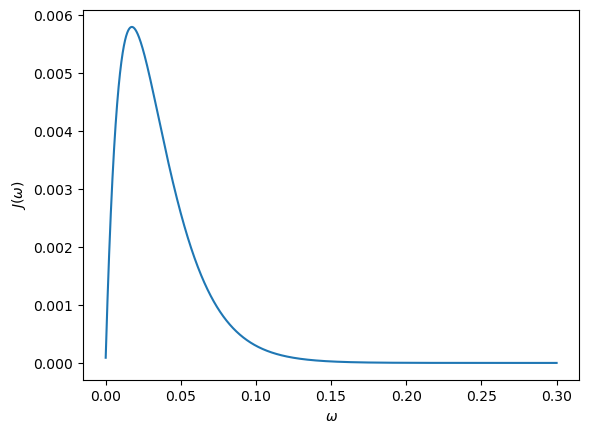

In [24]:
plt.plot(omega[omega >= 0], spectral_density(eta, omega_c, omega[omega >= 0]))
plt.ylabel(r'$J(\omega)$'); plt.xlabel(r'$\omega$');

The spectral density is used to calculate two important functions: the spectral function

$$
C(\omega) = \int_{-\infty}^\infty dt c(t) e^{i\omega t} = \frac{2 J(\omega)}{1 - e^{-\beta \omega}}
$$

which is the Fourier transform of the bath correlation function $c(t)$

In [25]:
def spectral_function(eta, omega_c, beta, omega):
    sd = spectral_density(eta, omega_c, omega)
    if beta != np.inf:
        sf = np.where(np.isclose(omega, 0, atol=1e-10), 2 * eta / beta, 2 * sd / (1 - np.exp(- beta * omega)))
    else:
        sf = np.where(omega >= 0, 2 * sd, 0)
    return sf

and the dispersion function

$$
\Lambda(\omega) = \frac{1}{2\pi} \mathcal{P} \int_{-\infty}^\infty d\omega' \frac{C(\omega')}{\omega-\omega'}
$$

where $\mathcal{P}$ is the principal value of the integral.

In [26]:
def dispersion_function(eta, omega_c, beta, omega):
    original_shape = np.shape(omega)
    omega_array = np.reshape(omega, np.size(omega))
    
    domega_ax = 1e-4
    omega_max_ax = 0.3
    omega_ax = np.arange(-omega_max_ax, omega_max_ax + domega, domega)
    sf = spectral_function(eta, omega_c, beta, omega_ax)
    
    df = np.zeros_like(omega_array)
    
    for i in range(np.size(omega_array)):
        function = np.where(np.isclose(omega_ax, omega_array[i], atol=1e-10), 0, sf / (omega_array[i] - omega_ax) / 2 / pi)
        df[i] = np.trapz(function, dx = domega, axis = 0)
        
    df = np.reshape(df, original_shape)
    return df

Both of them depends on the thermodynamic beta $\beta = (k_B T)^{-1}$, i.e., on the temperature of the environment.
Here, we assume zero temperature, which means $\beta = \infty$.

In [27]:
beta = np.inf                                    # Inverse temperature of the environment

Let's plot them (note that the lower the $\beta$, the higher the simmetry along $\omega$)

C:\Users\fede\AppData\Local\Temp\ipykernel_21820\2638030793.py:13: RuntimeWarning: invalid value encountered in divide
  function = np.where(np.isclose(omega_ax, omega_array[i], atol=1e-10), 0, sf / (omega_array[i] - omega_ax) / 2 / pi)
C:\Users\fede\AppData\Local\Temp\ipykernel_21820\2638030793.py:13: RuntimeWarning: divide by zero encountered in divide
  function = np.where(np.isclose(omega_ax, omega_array[i], atol=1e-10), 0, sf / (omega_array[i] - omega_ax) / 2 / pi)


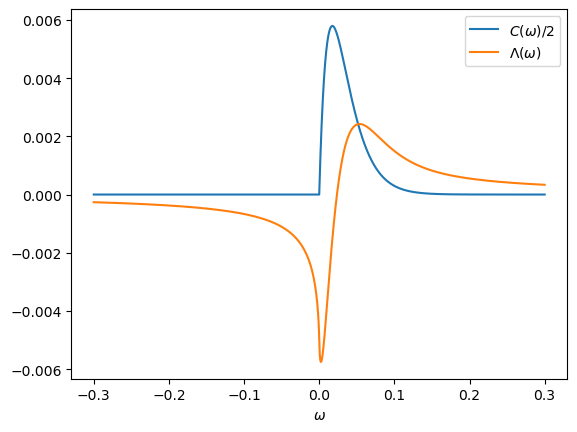

In [28]:
plt.plot(omega, spectral_function(eta, omega_c, beta, omega) / 2)
plt.plot(omega, dispersion_function(eta, omega_c, beta, omega))
plt.legend([r'$C(\omega) / 2$', r'$\Lambda(\omega)$'])
plt.xlabel(r'$\omega$');

These functions are the real and imaginary components of the Fourier-Laplace transform of the bath correlation function  𝑐(𝑡)

$$
\Gamma (\omega) = \int_{0}^\infty dt c(t) e^{i\omega t} = \frac{1}{2} C (\omega) + i \Lambda(\omega)
$$

For the Redfield dynamics, we will need to evaluate these functions at the system frequencies.

In [29]:
freq_sys = np.subtract.outer(eigval_S, eigval_S) # Frequencies of the system

C = spectral_function(eta, omega_c, beta, freq_sys) # Spectral function
Lambda = dispersion_function(eta, omega_c, beta, freq_sys) # Dispersion function
Gamma = C / 2 + 1.j * Lambda # Gamma

The Redfield equation in the secular approximation reads

$$
\frac{d\rho(t)}{dt} = - i [ H_S,\rho(t) ] - \sum_\omega \Gamma(\omega) [ Q^\dagger(\omega), Q(\omega) \rho(t) ] + \Gamma^*(\omega) [ \rho(t) Q^\dagger(\omega), Q(\omega) ]
$$

where

$$
Q(\omega) = \sum_{i,j} Q_{ij} | i \rangle \langle j | \delta \left( E_j - E_i, \omega \right)
$$

with $Q_{ij} = \langle i | Q | j \rangle$ and $\delta \left( E_j - E_i, \omega \right)$ the extension of the Kronecker delta function in the continuous space.
If we consider a non-degenerate Hamiltonian, it is possible to further simplify the expression as

$$
Q(\omega = \omega_{ji}) = 
\begin{cases}
    Q_{ij} | i \rangle \langle j |, & \text{for }i \neq j \Rightarrow \omega \neq 0\\
    \\
    \sum_{i} Q_{ii} | i \rangle \langle i |, & \text{for }i = j \Rightarrow \omega=0
\end{cases}
$$

Here, we consider two possibilities:
- $Q_I = P_1 (1 - \text{cos}\varphi )$
- $Q_{II} = P_0 (1 + \text{cos}\varphi )$

In [30]:
def Q(number, eigvec_S):
    N_rotor = np.shape(eigvec_S)[0]//2
    if number == 1:
        P1 = np.array([[0, 0], [0, 1]], dtype=complex)
        qt = np.eye(N_rotor, dtype=complex) - 1/2 * (np.diag(np.ones(N_rotor-1, dtype=complex), k=-1) + np.diag(np.ones(N_rotor-1, dtype=complex), k=1))
        q = np.conj(eigvec_S).T @ np.kron(P1, qt) @ eigvec_S
    if number == 2:
        P0 = np.array([[1, 0], [0, 0]], dtype=complex)
        qc = np.eye(N_rotor, dtype=complex) + 1/2 * (np.diag(np.ones(N_rotor-1, dtype=complex), k=-1) + np.diag(np.ones(N_rotor-1, dtype=complex), k=1))
        q = np.conj(eigvec_S).T @ np.kron(P0, qc) @ eigvec_S
    return (q + np.conj(q).T)/2 # Here I am just enforcing the Hermiticity of Q

For smaller systems it is possible to solve the Redfield equation by exploiting vectorization of the denisity matrix (see for example J. A. Gyamfi, Fundamentals of quantum mechanics in Liouville space, _Eur. J. Phys._ **41** (2020) 063002 [10.1088/1361-6404/ab9fdd](https://doi.org/10.1088/1361-6404/ab9fdd)).
In this case it would be necessary to store a Redfield tensor with $(2N)^4$ elements, which is beyond the possibilities of the RAM of a PC.
Moreover, in this case most of the tensor is empty.

For this reason, here we distinguish between the evolution of populations (diagonal terms of the density matrix)

$$
\frac{d\rho_{ii}(t)}{dt} = \sum_{j \neq i} C(\omega_{ji}) |Q_{ij}|^2 \rho_{jj}(t) - \rho_{ii}(t) \sum_{j \neq i} C(\omega_{ij}) |Q_{ji}|^2
$$

In [31]:
def Map_populations(time, q, C):
    W = C.T * np.abs(q)**2
    W -= np.diag(np.diag(W))
    W -= np.diag(np.sum(W, axis=0))
    return expm(W * time)

and that of coherences (off-diagonal terms of the density matrix)

$$
\frac{d\rho_{ij}(t)}{dt} = - ( i \omega_{ij} + \gamma_{ij}) \rho_{ij}
$$

with

$$
\gamma_{ij} = \sum_{l} \left( \Gamma(\omega_{il}) |Q_{il}|^2 + \Gamma^*(\omega_{jl}) |Q_{jl}|^2 \right) - C(0) Q_{ii} Q_{jj}
$$

In [32]:
def Map_elementwise_coherences(time, q, freq_sys, Gamma):
    # Assuming non-degenerate Hamiltonian
    A = Gamma * np.abs(q)**2
    B = np.conj(Gamma) * np.abs(q)**2
    A = np.sum(A, axis = 1)
    B = np.sum(B, axis = 1)
    B_mesh, A_mesh = np.meshgrid(B, A)
    gamma = A_mesh + B_mesh
    # Accounting for terms at frequency = 0
    A = np.diag(q)
    B_mesh, A_mesh = np.meshgrid(A, A)
    gamma -= 2 * np.real(Gamma[0,0]) * B_mesh * A_mesh
    # Removing the diagonal
    gamma -= np.diag(np.diag(gamma))
    return np.exp(- 1.j * freq_sys * time - gamma * time)

We are ready for the dynamics!

We define a time array

In [33]:
dt_ps = 0.03                                     # Time step [ps]
tmax_ps = 20                                     # Max time [ps]
t_ps = np.arange(0, tmax_ps, dt_ps)              # Time array [ps]
dt = dt_ps / 0.004136 * 2 * pi                   # Time step [1/eV]
tmax = tmax_ps / 0.004136 * 2 * pi               # Max time [1/eV]
t = t_ps / 0.004136 * 2 * pi                     # Time array [1/eV]

We assume the initial state to be prepared from an electronic excitation of the ground state of $H_S$ ($| \Psi^S_0 \rangle$)

$$
| \Psi (0) \rangle = \sigma^x \otimes \mathbb{1} | \Psi^S_0 \rangle
$$

i.e.

$$
\rho (t) = | \Psi (0) \rangle \langle \Psi (0) |
$$

In [34]:
Psi_0 = np.zeros((N_rotor_states * 2), dtype=complex)
Psi_0[0] = 1
Psi_0 = np.conj(eigvec_S).T @ np.kron(np.array([[0, 1], [1, 0]]), np.eye(N_rotor_states)) @ eigvec_S @ Psi_0
rho_0 = np.outer(np.conj(Psi_0), Psi_0)
rho_a_tutti_i_tempi = np.zeros((np.shape(rho_0)[0], np.shape(rho_0)[1], len(t)), dtype=complex)
rho_a_tutti_i_tempi[:,:,0] = rho_0

We evolve the Redfield dynamics

In [35]:
q = Q(1, eigvec_S)
M_p = Map_populations(dt, q, C)
M_e_c = Map_elementwise_coherences(dt, q, freq_sys, Gamma)
for i in range(1, len(t)):
    Pops = np.diag(rho_a_tutti_i_tempi[:,:,i-1]) # Extract the populations from the density matrix
    Coherences = rho_a_tutti_i_tempi[:,:,i-1] - np.diag(np.diag(rho_a_tutti_i_tempi[:,:,i-1])) # Extract the coherences from the density matrix
    Pops = M_p @ Pops # Evolve the populations
    Coherences = M_e_c * Coherences # Evolve the coherences
    rho_a_tutti_i_tempi[:,:,i] = np.diag(Pops) + Coherences # Compose the density matrix

Finally, we plot the dynamics of the observables

C:\Users\fede\AppData\Local\Temp\ipykernel_21820\1911968536.py:21: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 2, 'A', False, aligned=True), Array(complex128, 2, 'C', False, aligned=True))
  P_0_t[i] = np.trace(states[:,:,i] @ P0t)
C:\Users\fede\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


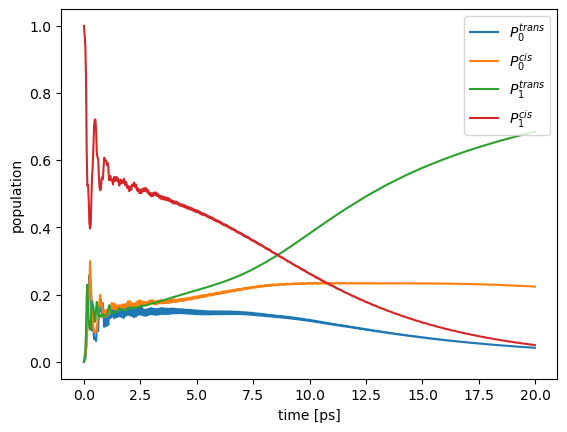

In [36]:
P = observables(t, rho_a_tutti_i_tempi, P0t, P0c, P1t, P1c)
[plt.plot(t_ps, P[i]) for i in range(4)]
plt.legend([r'$P_0^{trans}$',r'$P_0^{cis}$',r'$P_1^{trans}$',r'$P_1^{cis}$'], loc=1)
plt.xlabel('time [ps]'); plt.ylabel('population');

What does population dynamics tell us?

Why don't we see the formation of a thermal state?